In [1]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    to_date, first, last, max as _max, min as _min, sum as _sum, avg, 
    input_file_name, regexp_extract, col, log, exp, when
)
from pyspark.sql.window import Window

In [2]:
# Create Spark session with necessary JARs for S3 access
spark = SparkSession.builder \
    .appName("LinearRegressionModel") \
    .config("spark.jars.packages", 
            "org.apache.hadoop:hadoop-aws:3.3.4,"
            "com.amazonaws:aws-java-sdk-bundle:1.12.568") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config("spark.hadoop.fs.s3a.aws.credentials.provider", 
            "com.amazonaws.auth.profile.ProfileCredentialsProvider") \
    .config("spark.hadoop.fs.s3a.endpoint", "s3.amazonaws.com") \
        .config("spark.driver.memory", "8g") \
        .config("spark.executor.memory", "8g") \
    .getOrCreate()

In [ ]:
df = spark.read.parquet("s3a://cryptospark-dataset/archive/")

# Extract symbol from filename (e.g., 1INCH-BTC.parquet), and date from open_time column
df = df.withColumn("symbol", regexp_extract(input_file_name(), r"([^/]+)\.parquet$", 1)) \
    .withColumn("date", to_date("open_time"))

df.printSchema()
df.show(5)

root
 |-- open: float (nullable = true)
 |-- high: float (nullable = true)
 |-- low: float (nullable = true)
 |-- close: float (nullable = true)
 |-- volume: float (nullable = true)
 |-- quote_asset_volume: float (nullable = true)
 |-- number_of_trades: integer (nullable = true)
 |-- taker_buy_base_asset_volume: float (nullable = true)
 |-- taker_buy_quote_asset_volume: float (nullable = true)
 |-- open_time: timestamp_ntz (nullable = true)
 |-- symbol: string (nullable = false)
 |-- date: date (nullable = true)

+-------+-------+-------+-------+--------+------------------+----------------+---------------------------+----------------------------+-------------------+--------+----------+
|   open|   high|    low|  close|  volume|quote_asset_volume|number_of_trades|taker_buy_base_asset_volume|taker_buy_quote_asset_volume|          open_time|  symbol|      date|
+-------+-------+-------+-------+--------+------------------+----------------+---------------------------+-----------------------

# Preprocessing 0.1% of the data

In [4]:
# Drop unnecessary columns
processed_df = df.drop("quote_asset_volume", "number_of_trades", "taker_buy_base_asset_volume", "taker_buy_quote_asset_volume", "open_time")

# Drop rows with nulls in critical columns
processed_df = processed_df.dropna(subset=["open", "high", "low", "close", "volume", "date"])

In [5]:
sample_df = processed_df.sample(fraction=0.001, seed=42)
print("Rows:", sample_df.count())

Rows: 1506508


In [6]:
# repartition the DataFrame by symbol to optimize for groupBy operations
sample_df = sample_df.repartition("symbol")

sample_df = sample_df.groupBy("symbol", "date").agg(
    first("open").alias("open"),
    last("close").alias("close"),
    _max("high").alias("high"),
    _min("low").alias("low"),
    _sum("volume").alias("volume"),
)

In [7]:
# Add additional features, like daily return and volatility
sample_df = sample_df.withColumn("daily_return", (col("close") - col("open")) / col("open")) \
       .withColumn("volatility", (col("high") - col("low")) / col("open"))


In [8]:
sample_df = sample_df.repartition("symbol")

# Cumulative return
window_spec = Window.partitionBy("symbol").orderBy("date") \
    .rowsBetween(Window.unboundedPreceding, Window.currentRow)

# Moving Averages (7-day and 30-day)
window_7 = Window.partitionBy("symbol").orderBy("date").rowsBetween(-6, 0)
window_30 = Window.partitionBy("symbol").orderBy("date").rowsBetween(-29, 0)

# Calculate cumulative return and moving averages
sample_df = sample_df.withColumn("ma_7", avg("close").over(window_7)) \
    .withColumn("ma_30", avg("close").over(window_30)) \
    .withColumn("cumulative_return", exp(_sum(log(1 + col("daily_return"))).over(window_spec)) - 1) 

In [9]:
# Drop rows with nulls in critical columns
sample_df = sample_df.dropna(subset=["ma_7", "ma_30", "cumulative_return", "daily_return", "volatility"])

In [10]:
sample_df.cache()
sample_df.show(5)  # Materialize cache

+----------+----------+------+------+------+------+------------------+--------------------+--------------------+------------------+------------------+--------------------+
|    symbol|      date|  open| close|  high|   low|            volume|        daily_return|          volatility|              ma_7|             ma_30|   cumulative_return|
+----------+----------+------+------+------+------+------------------+--------------------+--------------------+------------------+------------------+--------------------+
|1INCH-USDT|2020-12-25|2.6776|   2.7|  2.71|2.6702|    53223.30078125| 0.00836575348857254|   0.014864031240172| 2.700000047683716| 2.700000047683716|0.008365753488572603|
|1INCH-USDT|2020-12-26|2.0483|1.5802|2.0589|1.5757|     87674.1328125|-0.22853100844085333|  0.2359029764550744|2.1401000022888184|2.1401000022888184|-0.22207708903339185|
|1INCH-USDT|2020-12-27|1.4774|1.3213|1.4775|1.2334|122158.81982421875|-0.10565853613665868| 0.16522267745817124|1.8671666781107585|1.8671666

# Logistic Regression

In [11]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [12]:
# Create a new column "label" for classification
final_df = sample_df.withColumn("label", when(sample_df.daily_return > 0, 1).otherwise(0))

In [13]:
# Select relevant columns for modeling
numeric_features = ['open', 'high', 'low', 'close', 'volume', 
                    'volatility', 'ma_7', 'ma_30', 'cumulative_return']

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=numeric_features, outputCol="features")

In [14]:
# Create a Logistics Regression model
lr = LogisticRegression(featuresCol='features', labelCol='label')

In [15]:
# Build a Pipeline for the model
pipeline = Pipeline(stages=[assembler, lr])

In [16]:
# Split the data into training and test sets
train_df, test_df = final_df.randomSplit([0.7, 0.3], seed=42)

In [17]:
# Train the linear regression model
model = pipeline.fit(train_df)

In [18]:
# Make predictions on the test set
predictions = model.transform(test_df)

# Evaluate the model using ROC-AUC
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions)

print(f"ROC-AUC: {roc_auc:.4f}")

ROC-AUC: 0.6984


# Visualizations

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# Convert prediction results to a pandas DataFrame
pandas_df = predictions.select("label", "prediction", "probability").sample(fraction=0.1).toPandas()

# Extract the probability for class 1
pandas_df["prob_class_1"] = pandas_df["probability"].apply(lambda x: float(x[1]))

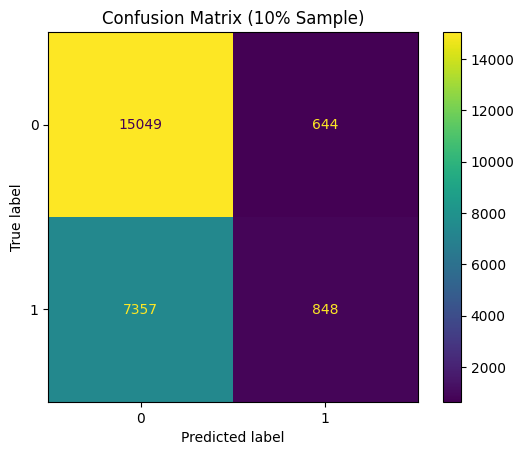

In [20]:
# Confusion Matrix
cm = confusion_matrix(pandas_df["label"], pandas_df["prediction"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix (10% Sample)")
plt.show()

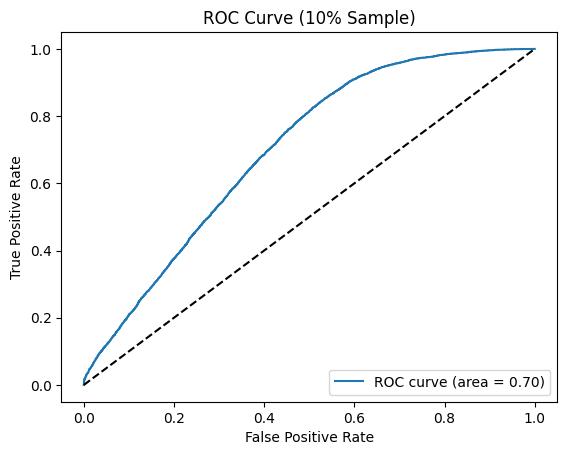

In [21]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(pandas_df["label"], pandas_df["prob_class_1"])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (10% Sample)')
plt.legend(loc="lower right")
plt.show()

# Save the Logistic Regression model

In [23]:
# Change model path according to your environment
# Save the model to a specified path
model_path = "C:/Users/dumas/OneDrive/Documents/GitHub/CryptoSpark/logisticRegression_model"

# Save the model
model.save(model_path)